# Basic Cell Clustering Using 100Kb Bins

## Content

Here we go through the basic steps to perform cell clustering using genome non-overlapping 100Kb bins as features. We start from raw methylation base count data stored in MCDS format. It can be used to quickly evaluate get an idea on cell-type composition in a single-cell methylome dataset (e.g., the dataset from a single experiment).

### Dataset used in this notebook
- Adult (age P56) male mouse brain primary motor cortex (MOp) snmC-seq2 data from Liu et al. 2021 {cite}`Liu2020-ab`

## Input
- MCDS files (contains chrom100k dim)
- Cell metadata

## Output
- Cell-by-100kb-bin AnnData with embedding coordinates and cluster labels.

## Import

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from ALLCools.mcds import MCDS
from ALLCools.clustering import tsne, significant_pc_test, log_scale
from ALLCools.plot import *

## Parameters

In [4]:
# change this to the path to your metadata
metadata_path = '../../data/Brain/MOp+CA.CellMetadata.csv.gz'

# Basic filtering parameters. 
# These are suggesting values, cutoff maybe different for different tissue and sequencing depths.
# To determine each cutoff more appropriately, one need to plot the distribution of each metric.
mapping_rate_cutoff = 0.5
mapping_rate_col_name = 'MappingRate'  # Name may change
final_reads_cutoff = 500000
final_reads_col_name = 'FinalmCReads'  # Name may change
mccc_cutoff = 0.03
mccc_col_name = 'mCCCFrac'  # Name may change
mch_cutoff = 0.2
mch_col_name = 'mCHFrac'  # Name may change
mcg_cutoff = 0.5
mcg_col_name = 'mCGFrac'  # Name may change

# change this to the paths to your MCDS files, 
# ALLCools.MCDS can handle multiple MCDS files automatically
mcds_path_list = [
    '../../data/Brain/3C-171206.mcds',
    '../../data/Brain/3C-171207.mcds',
    '../../data/Brain/9H-190212.mcds',
    '../../data/Brain/9H-190219.mcds',
]

# Dimension name used to do clustering
# This corresponding to AnnData .obs and .var
obs_dim = 'cell'  # observation
var_dim = 'chrom100k'  # feature

# feature cov cutoffs
min_cov = 500
max_cov = 3000

# Regions to remove during the clustering analysis
# change this to the path to ENCODE blacklist.
# The ENCODE blacklist can be download from https://github.com/Boyle-Lab/Blacklist/
black_list_path = '../../data/genome/mm10-blacklist.v2.bed.gz'
black_list_fraction = 0.2
exclude_chromosome = ['chrM', 'chrY']

# load to memory or not
load = True

# HVF
mch_pattern = 'CHN'
mcg_pattern = 'CGN'
n_top_feature = 20000

# PC cutoff
pc_cutoff = 0.1

# KNN
knn = -1  # -1 means auto determine

# Leiden
resolution = 1

## Load Cell Metadata

In [5]:
metadata = pd.read_csv(metadata_path, index_col=0)
print(f'Metadata of {metadata.shape[0]} cells')
metadata.head()

Metadata of 5535 cells


mCCCFrac  mCGFrac  mCHFrac  FinalmCReads  CellInputReadPairs  \
cell                                                                      
3C_M_0      0.00738  0.75953  0.02543     1195574.0             2896392   
3C_M_1      0.00938  0.77904  0.03741     1355517.0             3306366   
3C_M_10     0.00915  0.82430  0.03678     2815807.0             7382298   
3C_M_100    0.00978  0.79705  0.04231     2392650.0             5865154   
3C_M_1000   0.00776  0.78781  0.02789     1922013.0             4800236   

           MappingRate             Plate  Col384  Row384 CellTypeAnno  
cell                                                                   
3C_M_0        0.625773  CEMBA171206-3C-1      18       0       IT-L23  
3C_M_1        0.631121  CEMBA171206-3C-1      18       1        IT-L5  
3C_M_10       0.657560  CEMBA171206-3C-1      21       1          L6b  
3C_M_100      0.671600  CEMBA171206-3C-1       0       3    MGE-Pvalb  
3C_M_1000     0.646285  CEMBA171206-3C-4       3       8        IT-L6

## Filter Cells

In [6]:
judge = (metadata[mapping_rate_col_name] > mapping_rate_cutoff) & \
        (metadata[final_reads_col_name] > final_reads_cutoff) & \
        (metadata[mccc_col_name] < mccc_cutoff) & \
        (metadata[mch_col_name] < mch_cutoff) & \
        (metadata[mcg_col_name] > mcg_cutoff)

metadata = metadata[judge].copy()
print(f'{metadata.shape[0]} cells passed filtering')

4958 cells passed filtering


In [7]:
# Save
# metadata.to_csv('Brain.CellMetadata.PassQC.csv.gz')

## Load MCDS

In [8]:
mcds = MCDS.open(
    mcds_path_list, 
    obs_dim='cell', 
    use_obs=metadata.index  # MCDS contains all cells, this will select cells that passed filtering 
)
total_feature = mcds.get_index(var_dim).size
mcds

<xarray.MCDS>
Dimensions:              (cell: 4958, chrom100k: 27269, count_type: 2, gene: 55487, mc_type: 2)
Coordinates:
  * mc_type              (mc_type) object 'CGN' 'CHN'
  * cell                 (cell) object '3C_M_0' '3C_M_1' ... '9H_M_3061'
  * gene                 (gene) object 'ENSMUSG00000102693.1' ... 'ENSMUSG000...
  * count_type           (count_type) object 'mc' 'cov'
    strand_type          <U4 'both'
    gene_chrom           (gene) object dask.array<chunksize=(55487,), meta=np.ndarray>
    gene_start           (gene) int64 dask.array<chunksize=(55487,), meta=np.ndarray>
    gene_end             (gene) int64 dask.array<chunksize=(55487,), meta=np.ndarray>
  * chrom100k            (chrom100k) int64 0 1 2 3 4 ... 27265 27266 27267 27268
    chrom100k_chrom      (chrom100k) object dask.array<chunksize=(27269,), meta=np.ndarray>
    chrom100k_bin_start  (chrom100k) int64 dask.array<chunksize=(27269,), meta=np.ndarray>
    chrom100k_bin_end    (chrom100k) int64 dask.array<chunksize=(27269,), meta=np.ndarray>
Data variables:
    gene_da              (cell, gene, mc_type, count_type) uint16 dask.array<chunksize=(1199, 55487, 2, 2), meta=np.ndarray>
    chrom100k_da         (cell, chrom100k, mc_type, count_type) uint16 dask.array<chunksize=(1199, 27269, 2, 2), meta=np.ndarray>

In [9]:
# you can add the cell metadata into MCDS
mcds.add_cell_metadata(metadata)

## Filter Features

Feature chrom100k mean cov across cells added in MCDS.coords['chrom100k_cov_mean'].


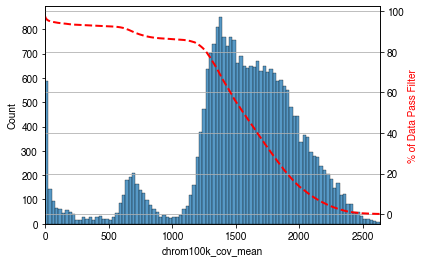

In [10]:
mcds.add_feature_cov_mean(var_dim=var_dim)

We saw three parts here, from coverage low to high, they are
1. Low coverage regions
2. chrX regions, because this dataset from male mouse brain
3. Other autosomal regions

In [11]:
# filter by coverage - based on the distribution above
mcds = mcds.filter_feature_by_cov_mean(
    var_dim=var_dim,
    min_cov=min_cov,  # minimum coverage
    max_cov=max_cov  # Maximum coverage
)

# remove blacklist regions
mcds = mcds.remove_black_list_region(
    var_dim,
    black_list_path,
    f=black_list_fraction  # Features having overlap > f with any black list region will be removed.
)

# remove chromosomes
mcds = mcds.remove_chromosome(var_dim, exclude_chromosome)

Before cov mean filter: 27269 chrom100k
 After cov mean filter: 25235 chrom100k 92.5%
1187 chrom100k features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.
18 chrom100k features in ['chrM', 'chrY'] removed.


## Calculate Feature mC Fractions

In [12]:
mcds.add_mc_frac(
    var_dim=var_dim, 
    normalize_per_cell=True,  # after calculating mC frac, per cell normalize the matrix
    clip_norm_value=10  # clip outlier values above 10 to 10
)

# load only the mC fraction matrix into memory so following steps is faster
# Only load into memory when you memory size is enough to handle your dataset
if load and (mcds.get_index(obs_dim).size < 20000):
    mcds[f'{var_dim}_da_frac'].load()

/home/hanliu/miniconda3/envs/allcools/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


The RuntimeWarning is expected (due to cov == 0). You can ignore it.

## Select Highly Variable Features (HVF)

### mCH HVF

In [13]:
mch_hvf = mcds.calculate_hvf_svr(var_dim=var_dim,
                                 mc_type=mch_pattern,
                                 n_top_feature=n_top_feature,
                                 plot=True)

Fitting SVR with gamma 0.0416, predicting feature dispersion using mc_frac_mean and cov_mean.
Total Feature Number:     24042
Highly Variable Feature:  20000 (83.2%)


### mCG HVF

In [14]:
mcg_hvf = mcds.calculate_hvf_svr(var_dim=var_dim,
                                 mc_type=mcg_pattern,
                                 n_top_feature=n_top_feature,
                                 plot=True)

Fitting SVR with gamma 0.0416, predicting feature dispersion using mc_frac_mean and cov_mean.
Total Feature Number:     24042
Highly Variable Feature:  20000 (83.2%)


## Get cell-by-feature mC fraction AnnData

In [15]:
mch_adata = mcds.get_adata(mc_type=mch_pattern,
                           var_dim=var_dim,
                           select_hvf=True)
mch_adata

AnnData object with n_obs × n_vars = 4958 × 20000
    obs: 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'FinalmCReads', 'CellInputReadPairs', 'MappingRate', 'Plate', 'Col384', 'Row384', 'CellTypeAnno'
    var: 'chrom', 'bin_start', 'bin_end', 'cov_mean', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'CGN_mean', 'CGN_dispersion', 'CGN_cov', 'CGN_score', 'CGN_feature_select'

In [16]:
mcg_adata = mcds.get_adata(mc_type=mcg_pattern,
                           var_dim=var_dim,
                           select_hvf=True)
mcg_adata

AnnData object with n_obs × n_vars = 4958 × 20000
    obs: 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'FinalmCReads', 'CellInputReadPairs', 'MappingRate', 'Plate', 'Col384', 'Row384', 'CellTypeAnno'
    var: 'chrom', 'bin_start', 'bin_end', 'cov_mean', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'CGN_mean', 'CGN_dispersion', 'CGN_cov', 'CGN_score', 'CGN_feature_select'

## Scale

In [17]:
log_scale(mch_adata)

In [18]:
log_scale(mcg_adata)

## PCA

### mCH PCA

46 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (4958, 50) to (4958, 46)
Red axis labels are used PCs


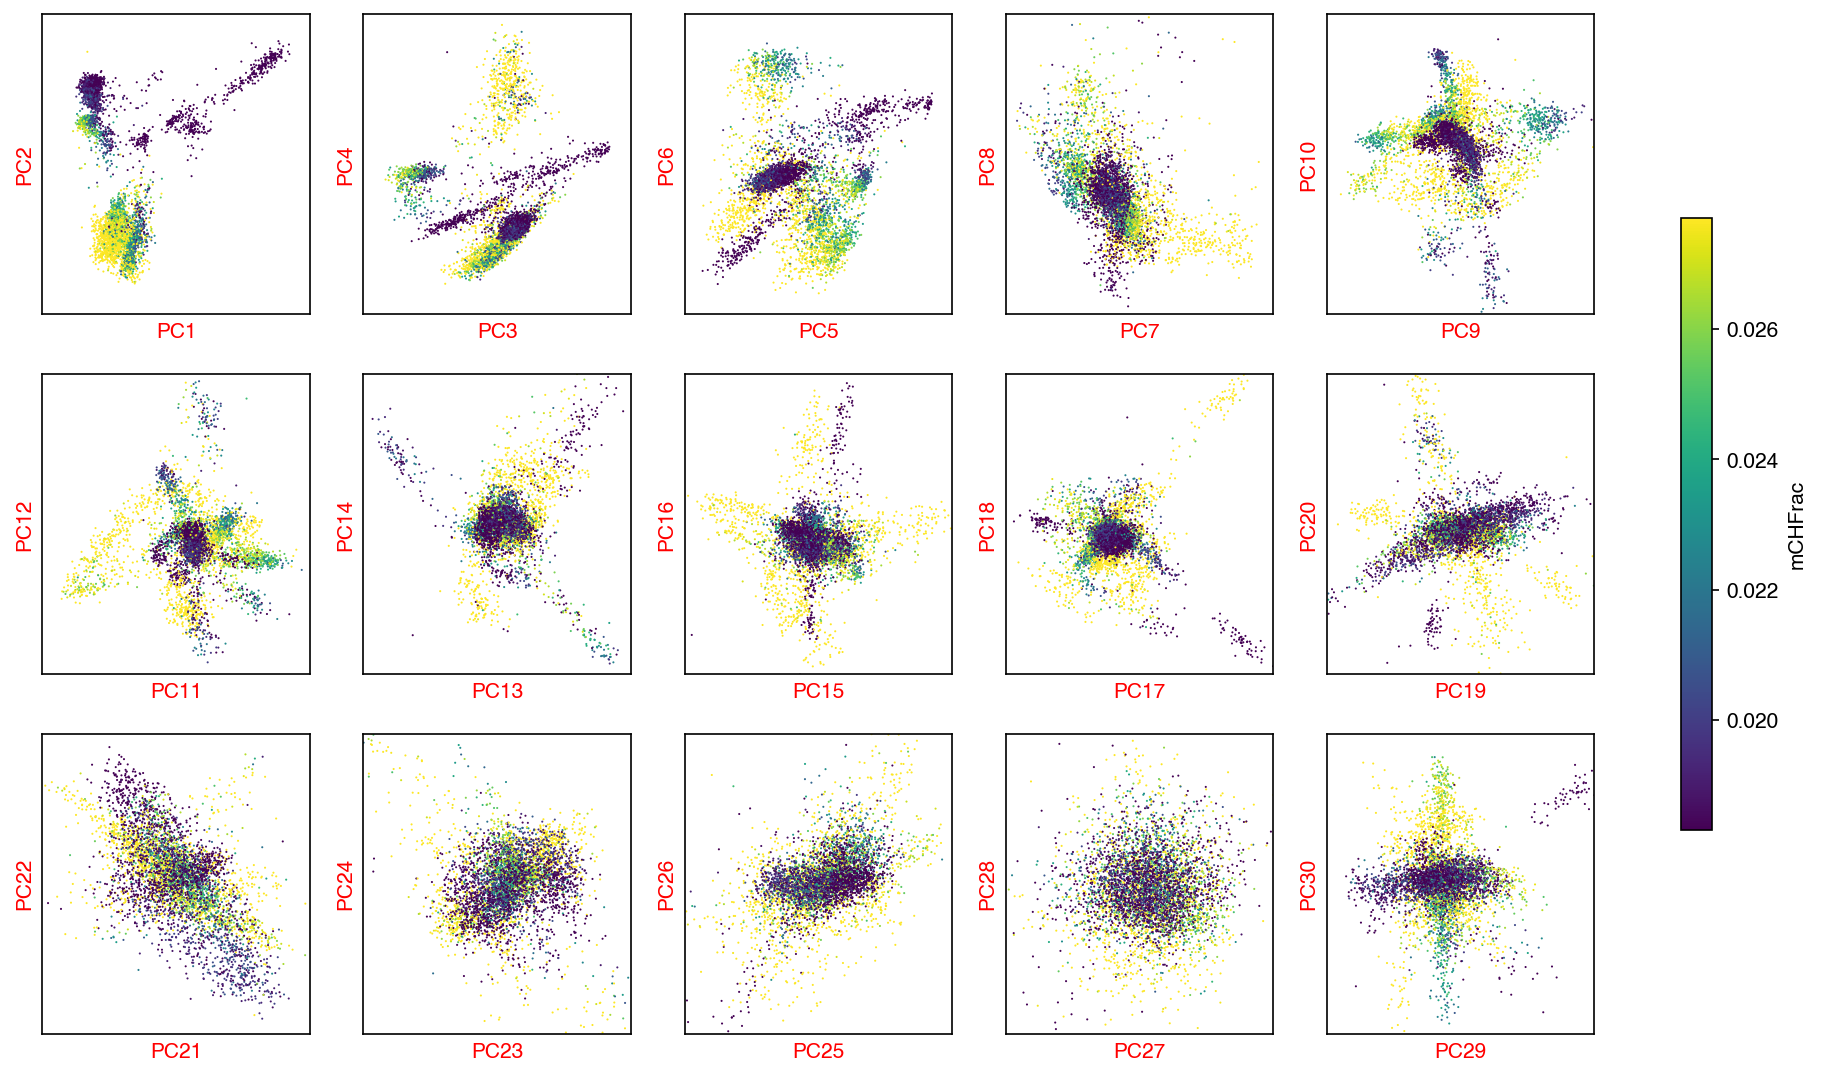

In [19]:
sc.tl.pca(mch_adata)
ch_n_components = significant_pc_test(mch_adata)
fig, axes = plot_decomp_scatters(mch_adata,
                                 n_components=ch_n_components,
                                 hue=mch_col_name,
                                 hue_quantile=(0.25, 0.75),
                                 nrows=3,
                                 ncols=5)

### mCG PCA

33 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (4958, 50) to (4958, 33)
Red axis labels are used PCs


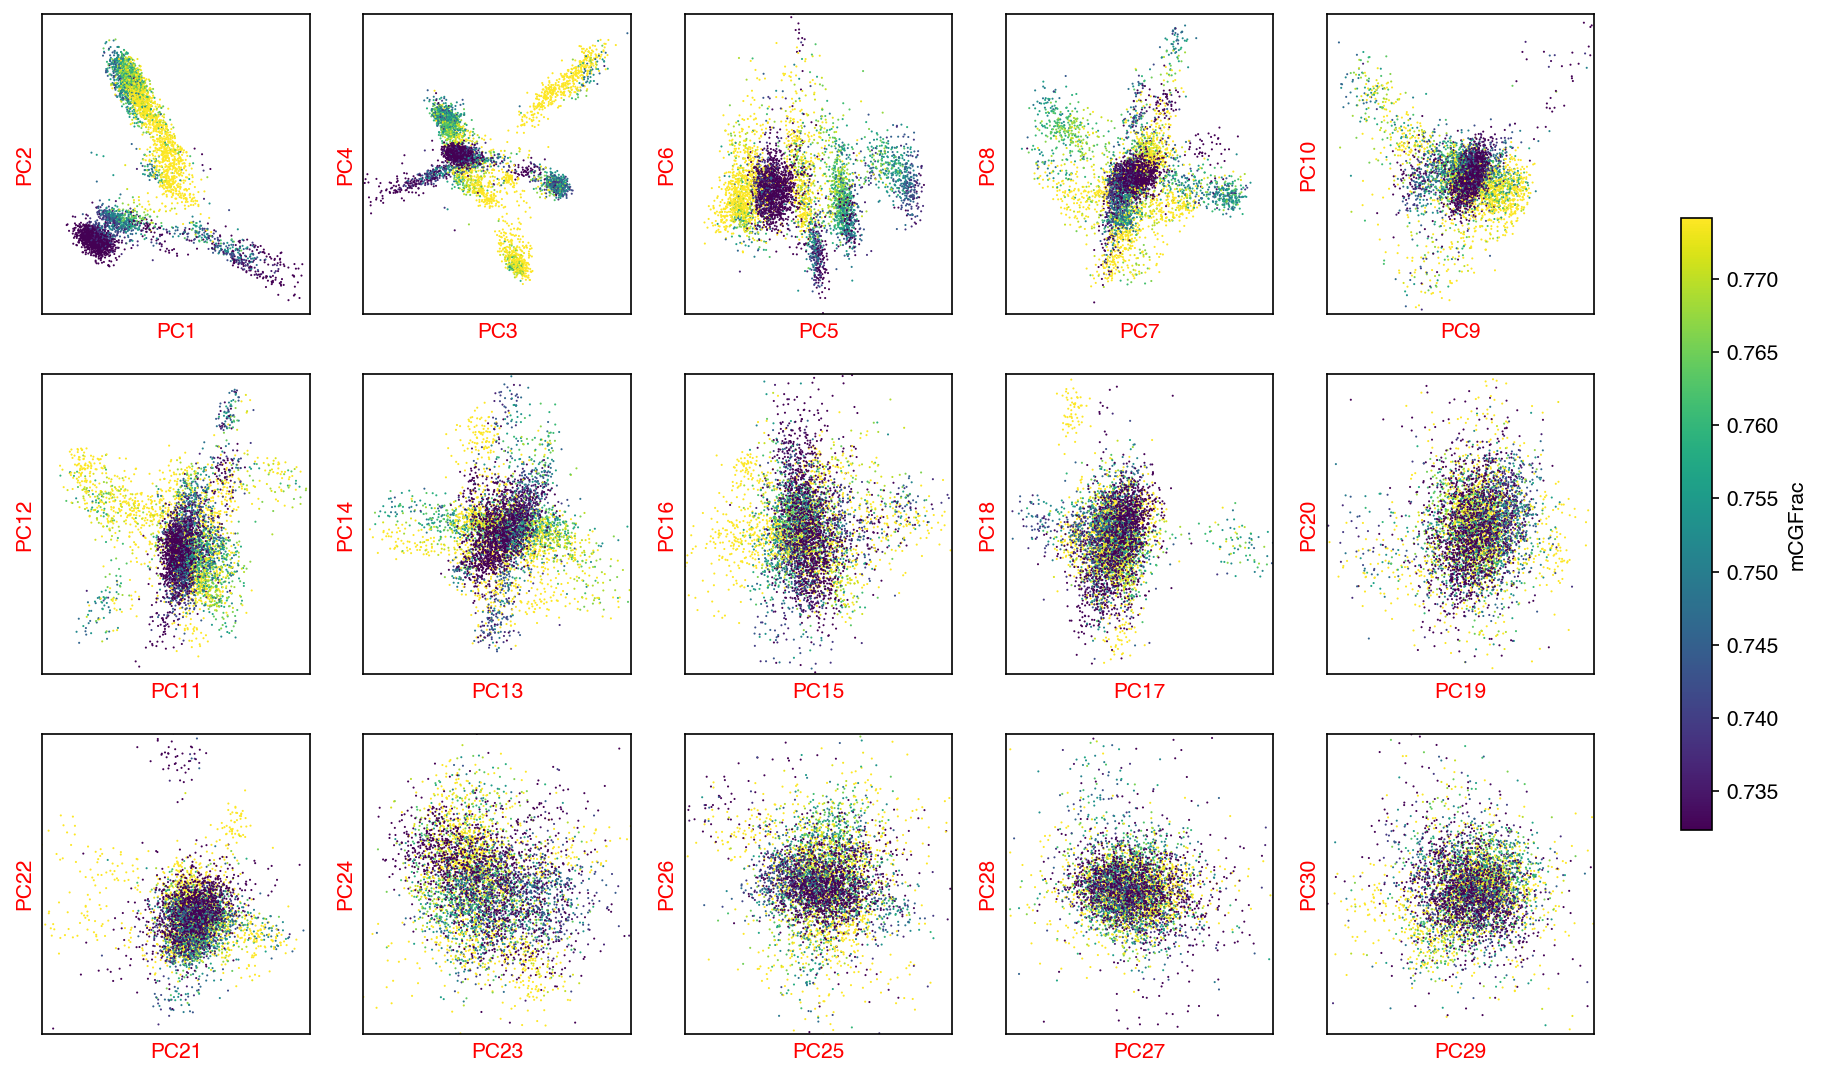

In [20]:
sc.tl.pca(mcg_adata)
cg_n_components = significant_pc_test(mcg_adata)
fig, axes = plot_decomp_scatters(mcg_adata,
                                 n_components=cg_n_components,
                                 hue=mcg_col_name,
                                 hue_quantile=(0.25, 0.75),
                                 nrows=3,
                                 ncols=5)

### Concatenate PCs

In [21]:
ch_pcs = mch_adata.obsm['X_pca'][:, :ch_n_components]
cg_pcs = mcg_adata.obsm['X_pca'][:, :cg_n_components]

# scale the PCs so CH and CG PCs has the same total var
cg_pcs = cg_pcs / cg_pcs.std()
ch_pcs = ch_pcs / ch_pcs.std()

# total_pcs
total_pcs = np.hstack([ch_pcs, cg_pcs])

# make a copy of adata, add new pcs
# this is suboptimal, will change this when adata can combine layer and X in the future
adata = mch_adata.copy()
adata.obsm['X_pca'] = total_pcs
del adata.uns['pca']
del adata.varm['PCs']

## Clustering

### Calculate Nearest Neighbors

In [22]:
if knn == -1:
    knn = max(15, int(np.log2(adata.shape[0])*2))
sc.pp.neighbors(adata, n_neighbors=knn)

### Leiden Clustering

In [23]:
sc.tl.leiden(adata, resolution=resolution)

## Manifold learning

In [24]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return adata

### tSNE

In [25]:
tsne(adata,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)
adata = dump_embedding(adata, 'tsne')

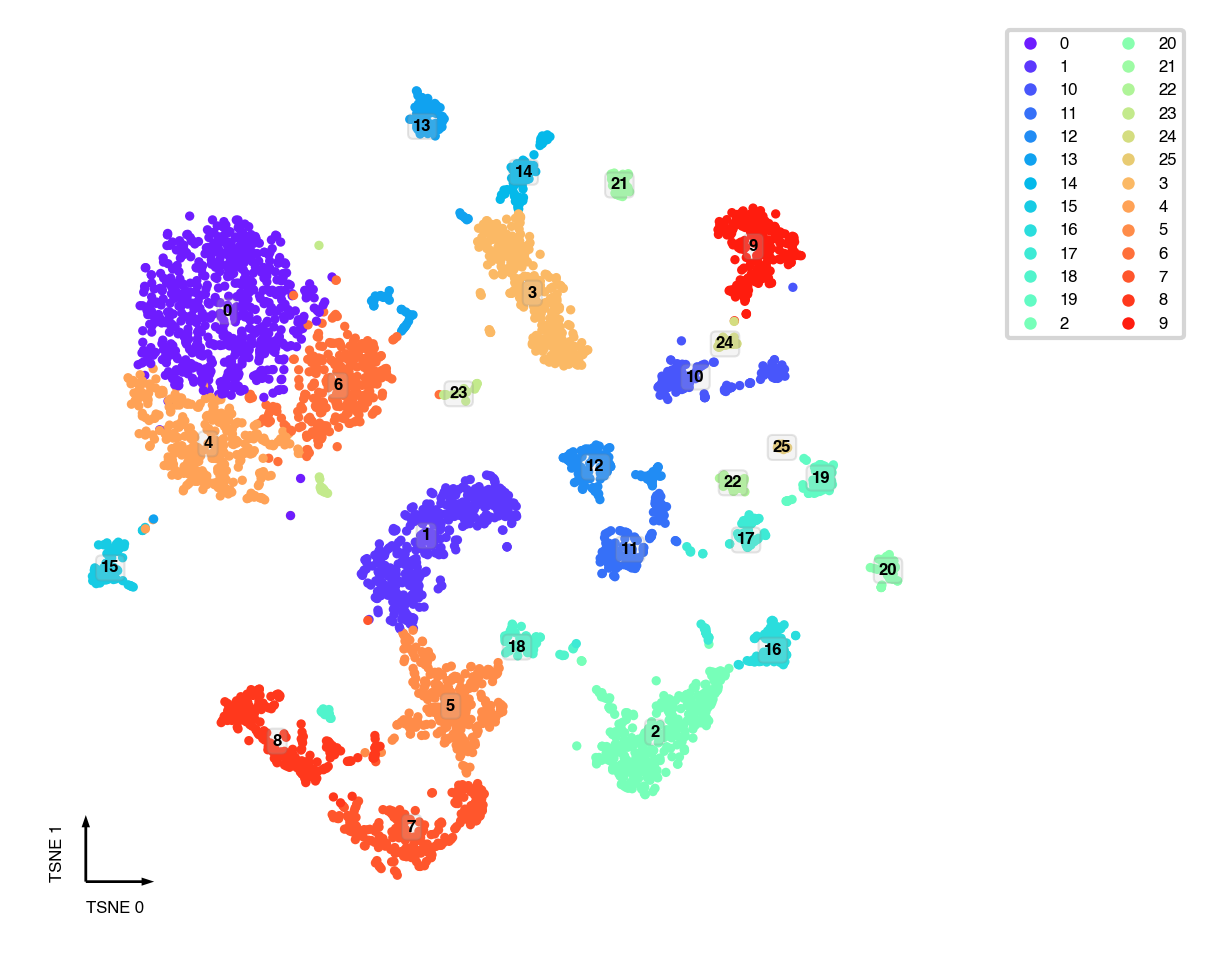

In [26]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
_ = categorical_scatter(data=adata.obs,
                        ax=ax,
                        coord_base='tsne',
                        hue='leiden',
                        text_anno='leiden',
                        show_legend=True)

### UMAP

In [27]:
sc.tl.umap(adata)
adata = dump_embedding(adata, 'umap')

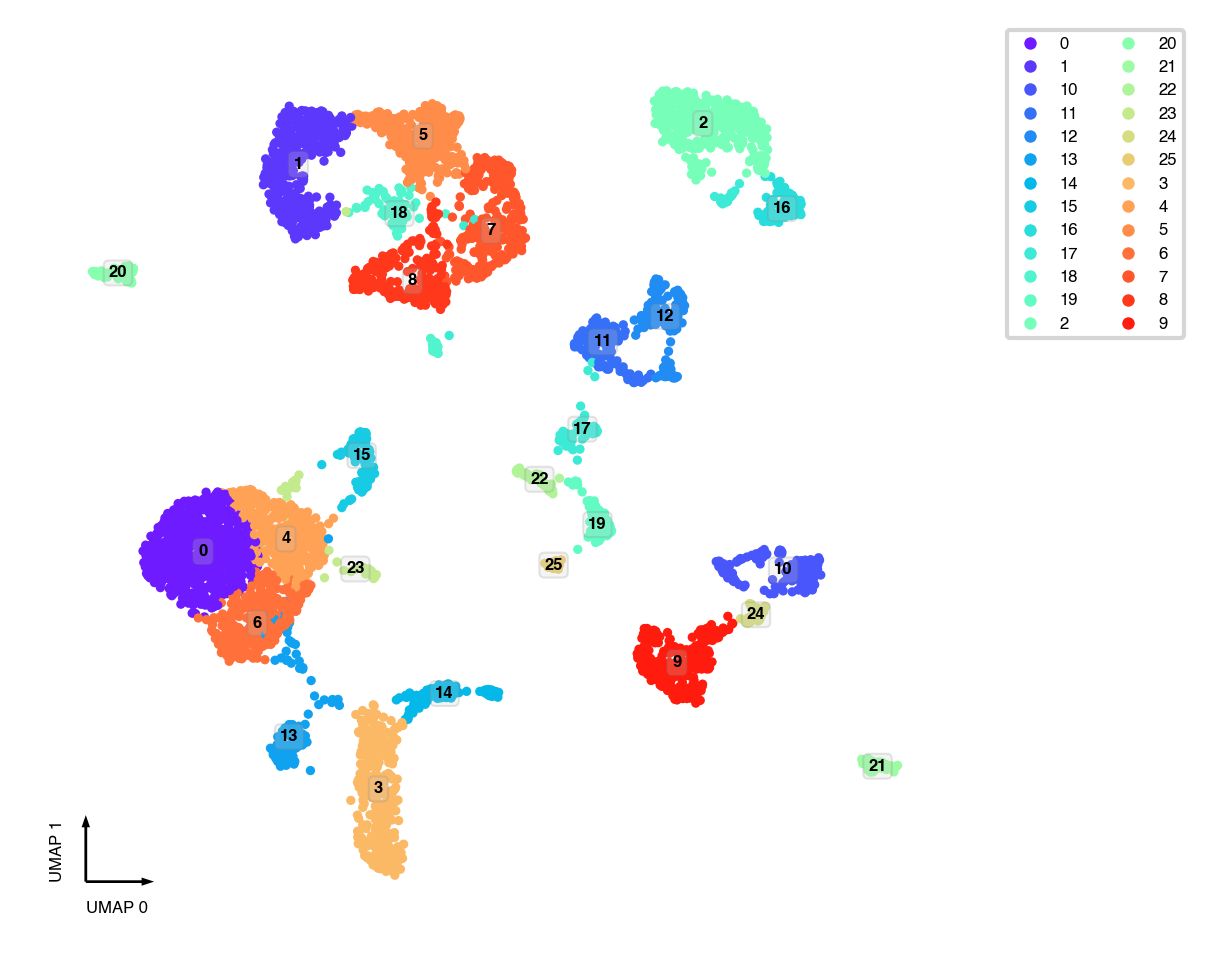

In [28]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
_ = categorical_scatter(data=adata.obs,
                        ax=ax,
                        coord_base='umap',
                        hue='leiden',
                        text_anno='leiden',
                        show_legend=True)

### Interactive plot

In [29]:
# in order to reduce the page size, I downsample the data here, you don't need to do this
interactive_scatter(data=adata.obs.sample(2500),
                    hue='leiden',
                    coord_base='umap')

## Save Results

In [30]:
adata.write_h5ad('Brain.chrom100k-clustering.h5ad')
adata

... storing 'Plate' as categorical
... storing 'CellTypeAnno' as categorical
... storing 'chrom' as categorical
... storing 'CHN_feature_select' as categorical
... storing 'CGN_feature_select' as categorical


AnnData object with n_obs × n_vars = 4958 × 20000
    obs: 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'FinalmCReads', 'CellInputReadPairs', 'MappingRate', 'Plate', 'Col384', 'Row384', 'CellTypeAnno', 'leiden', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1'
    var: 'chrom', 'bin_start', 'bin_end', 'cov_mean', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'CGN_mean', 'CGN_dispersion', 'CGN_cov', 'CGN_score', 'CGN_feature_select', 'mean', 'std'
    uns: 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'

In [31]:
adata.obs.to_csv('Brain.ClusteringResults.csv.gz')
adata.obs.head()

mCCCFrac  mCGFrac  mCHFrac  FinalmCReads  CellInputReadPairs  \
cell                                                                      
3C_M_0      0.00738  0.75953  0.02543     1195574.0             2896392   
3C_M_1      0.00938  0.77904  0.03741     1355517.0             3306366   
3C_M_10     0.00915  0.82430  0.03678     2815807.0             7382298   
3C_M_100    0.00978  0.79705  0.04231     2392650.0             5865154   
3C_M_1000   0.00776  0.78781  0.02789     1922013.0             4800236   

           MappingRate             Plate  Col384  Row384 CellTypeAnno leiden  \
cell                                                                           
3C_M_0        0.625773  CEMBA171206-3C-1      18       0       IT-L23      1   
3C_M_1        0.631121  CEMBA171206-3C-1      18       1        IT-L5      7   
3C_M_10       0.657560  CEMBA171206-3C-1      21       1          L6b     17   
3C_M_100      0.671600  CEMBA171206-3C-1       0       3    MGE-Pvalb     12   
3C_M_1000     0.646285  CEMBA171206-3C-4       3       8        IT-L6      8   

              tsne_0     tsne_1     umap_0     umap_1  
cell                                                   
3C_M_0    -11.139875 -15.762432  -3.623681  17.501331  
3C_M_1     -6.579434 -54.337190   4.043960  13.578933  
3C_M_10    33.050502 -21.641134  12.262009  14.793456  
3C_M_100   14.769778   4.253514   9.633595  12.044572  
3C_M_1000 -28.681991 -32.108992  -1.178329  12.580446

## Sanity test

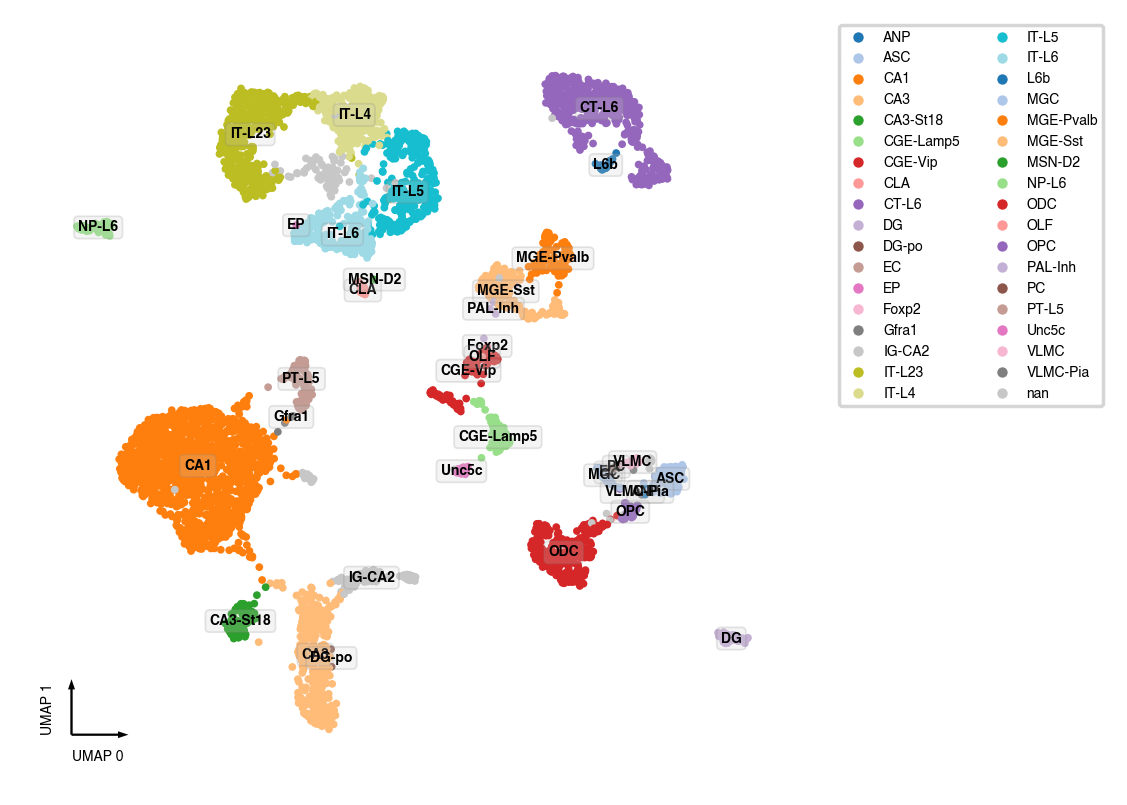

In [32]:
# This test dataset come from Liu et al. 2021 Nature, so we already annotated the cell types
# For new datasets, see following notebooks about identifying cluster markers and annotate clusters
if 'CellTypeAnno' in adata.obs:
    fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
    _ = categorical_scatter(data=adata.obs,
                            ax=ax,
                            coord_base='umap',
                            hue='CellTypeAnno',
                            text_anno='CellTypeAnno',
                            palette='tab20',
                            show_legend=True)

You may notice that here is an outlier population (nan) near the IT-L4, IT-L5, IT-L6, which is likely correspond to potential doublets. We can identify doublets using the MethylScrublet notebook.